In [1]:
# %pip uninstall boardlib
# %pip install boardlib
%pip install pandas
%pip install pandasgui
%pip install scipy
# Download the kilter dataset by running this in the terminal:
# boardlib database kilter ./kilter.db

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sqlite3
import boardlib
import pandas as pd
# from pandasgui import show
import matplotlib.pyplot as plt
import scipy.sparse as sp

In [3]:

con = sqlite3.connect('kilter.db')
cur = con.cursor()
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
table_names = [entry[0] for entry in table_list]
table_names.sort()
print(table_names)
con.close()

['android_metadata', 'ascents', 'attempts', 'beta_links', 'bids', 'circuits', 'circuits_climbs', 'climb_cache_fields', 'climb_random_positions', 'climb_stats', 'climbs', 'difficulty_grades', 'holes', 'kits', 'layouts', 'leds', 'placement_roles', 'placements', 'product_sizes', 'product_sizes_layouts_sets', 'products', 'products_angles', 'sets', 'shared_syncs', 'tags', 'user_permissions', 'user_syncs', 'users', 'wall_expungements', 'walls', 'walls_sets']


In [4]:
def table_to_df(table_name):
    con = sqlite3.connect('kilter.db')

    df =  pd.read_sql_query(f"SELECT * FROM {table_name}", con)
    
    con.close()

    return df

In [56]:
# get all tables as dfs
for table_name in table_names:
    globals()[table_name] = table_to_df(table_name)
# print("The available dataframes are: \n\t" + "\n\t".join(table_names))

,uuid,layout_id,setter_id,setter_username,name,description,hsm,edge_left,edge_right,edge_bottom,edge_top,angle,frames_count,frames_pace,frames,is_draft,is_listed,created_at
0,002047402B6941CEA5ED7BB09FBFE14D,1,1051,kilterjackie,4/26 Harder Than It Should Be,,3,40,136,4,152,NaN,1,0,p1145r12p1146r12p1149r13p1186r13p1201r13p1256r...,0,0,2018-04-27 03:31:54.979371
1,002ED50792A94E5EB2127D59E167B2EE,1,17760,bctyner,what kind of triangle,Make sure you angle your body just right,3,4,140,4,152,NaN,1,0,p1123r12p1139r13p1155r12p1171r13p1187r13p1203r...,0,0,2020-01-05 17:57:32.213641
2,003FF8E4DA8448E39696635E6DBD7B7C,1,8494,progressionclimbing,this is a statement,,1,8,136,16,144,NaN,1,0,p1102r13p1123r13p1124r12p1127r12p1134r13p1148r...,0,0,2019-12-21 21:13:17.697354
3,004FB7A0C0754DA98634C5EE4D985D9A,1,45676,jefferoni,SpEeD cLiMbInG,,1,8,136,8,152,NaN,1,0,p1081r15p1090r13p1091r13p1094r12p1097r13p1098r...,0,0,2021-03-11 05:57:44.333209
4,00683d10a8e246b3a106531c8573f13c,1,44916,mark.nalder,marks 1 try,,3,4,40,4,152,NaN,1,0,p1141r15p1142r12p1144r15p1179r12p1192r13p1246r...,0,0,2020-10-20 21:31:19.064510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180782,FFF50718FDC84AC39E161C459117D558,1,104245,gmg,La gRiMpE aVec dEs MoUvEmeNts,Marions 5 ans,1,48,80,8,88,25.0,1,0,p1082r15p1084r15p1096r15p1097r15p1098r15p1130r...,0,1,2024-02-24 16:17:45.632613
180783,FFF56A246F794AE68BE48A07690CAB90,1,59522,NickSip,Cyborg,An easy warm up route for Ghisolfi,3,40,136,4,152,50.0,1,0,p1136r12p1225r13p1273r13p1325r13p1370r13p1383r...,0,1,2024-02-07 12:58:07.805303
180784,fff7a4d83cc14eaf94b395fcf278bcae,1,99476,ericlimber,LIMBER IS BACK,,3,16,120,4,152,NaN,1,0,p1130r13p1172r12p1185r13p1186r13p1232r13p1295r...,0,0,2021-10-29 15:59:05.709765
180785,fff8c909fe7b40aaa29d845e518b18a9,1,216516,Koert_Hup,Monkey nuts (revived),Revived a removed boulder,3,8,136,4,152,40.0,1,0,p1133r15p1144r12p1163r12p1192r13p1210r13p1242r...,0,1,2024-02-04 19:01:05.875682


In [6]:
def map_vgrade(difficulty):
    if 33 > difficulty < 10:
        return None  # Return None if difficulty is outside the defined range
    
    # Simple formula for difficulty 10-21
    if difficulty < 22:
            return (difficulty - 10) // 2
    
    # Define thresholds:difficulties for direct mapping to simplify logic
    thresholds = {22: 6, 
                  23: 7, 
                  24: 8, 
                  26: 9, 
                  28: 10, 
                  29: 11, 
                  30: 12, 
                  31: 13, 
                  32: 14, 
                  33: 15}
    
    # Return the score for the highest threshold if difficulty is at or above the highest threshold
    for threshold, score in thresholds.items():
        if difficulty < threshold:
            return score - 1
    
    # Return the highest score if difficulty is above the highest threshold
    return max(thresholds.values())

### Create DF with necessary columns and data

In [57]:
# print(globals()['ascents'].head().to_string(index=False))
# climb_cache_fields = globals()['climb_cache_fields']
merged_df = pd.merge(climbs, climb_stats, left_on='uuid', right_on='climb_uuid', how='inner') #.drop(columns=['frames'])
# Drop rows with layout_id not equal to 1
merged_df = merged_df[merged_df['layout_id'] == 1]

# remove rows with more than 1 ascensionist
merged_df = merged_df[merged_df['ascensionist_count'] >= 2]
merged_df['vgrade'] = merged_df['display_difficulty'].apply(map_vgrade)

filtered_columns = ['name','vgrade','angle_y','display_difficulty','created_at', 'ascensionist_count','frames','fa_username', 'benchmark_difficulty',  'is_draft',  'climb_uuid']
filtered_df = merged_df.loc[:, filtered_columns]

# print(merged_df_filtered.head().to_string(index=False))
filtered_df.head()

# r12 - starthold  5
# r13 - hand hold  2
# r14 - finish hold 3
# r15 - foot hold   4
# p - hold position?

# p1454r15p1455r15p1457r15p1467r15p1469r15p1477r15p1485r15p1493r15p1511r15p1521r15p1532r15p1547r15p1549r15
# p1144r15 p1195r13 p1196r12 p1233r12 p1268r13 p1280r13 p1304r13 p1355r13 p1375r13 p1393r14 p1504r15 p1506r15 p1524r15 p1534r15 p1572r15 - EK | Crimp is not a crux

# p1085r15 p1124r12 p1176r12 p1196r13 p1244r13 p1283r13 p1332r13 p1383r14 p1385r14 p1504r15 p1514r15 - Pinch n' Gaston

# p1205r15 p1234r12 p1272r13 p1303r13 p1340r13 p1387r14 p1487r15 p1514r15 -sheep4wood

# p1165r12 p1271r13 p1286r13 p1333r14 p1469r15 p1476r15 - Fission

# p1146r12 p1163r12 p1227r13 p1249r13 p1265r13 p1269r14 p1457r15 p1467r15 p1484r15 p1496r15 p1503r15 p1506r15 p1516r15 - Plastic Age Mindset

# p1127r12 p1164r12 p1233r13 p1235r13 p1283r13 p1287r13 p1299r13 p1348r13 p1379r14 p1458r15 p1507r15 - anti-compressant

#layout_ids
# 1 - original board ( only meaningfulone)
# 2-8 ( other boards)


,name,vgrade,angle_y,display_difficulty,created_at,ascensionist_count,frames,fa_username,benchmark_difficulty,is_draft,climb_uuid
1,what kind of triangle,8.0,45,25.0000,2020-01-05 17:57:32.213641,2,p1123r12p1139r13p1155r12p1171r13p1187r13p1203r...,bctyner,NaN,0,002ED50792A94E5EB2127D59E167B2EE
4,marks 1 try,2.0,30,14.0000,2020-10-20 21:31:19.064510,2,p1141r15p1142r12p1144r15p1179r12p1192r13p1246r...,rob.hakansson,NaN,0,00683d10a8e246b3a106531c8573f13c
5,marks 1 try,2.0,55,14.3333,2020-10-20 21:31:19.064510,3,p1141r15p1142r12p1144r15p1179r12p1192r13p1246r...,mightybyte,NaN,0,00683d10a8e246b3a106531c8573f13c
9,dead points (tristyn) 1,3.0,30,17.5000,2020-10-20 23:37:41.285379,2,p1073r15p1151r12p1153r12p1173r15p1255r13p1258r...,nooc,NaN,0,00A14B4AA94B4E18B32DC9B047AC4545
10,easy clap,4.0,45,19.3333,2019-12-04 05:21:14.908093,3,p1328r13p1332r13p1333r13p1334r13p1336r13p1337r...,climbcentral,NaN,0,00A7E21491AB4701963AAFD114728697


### Some Graphs

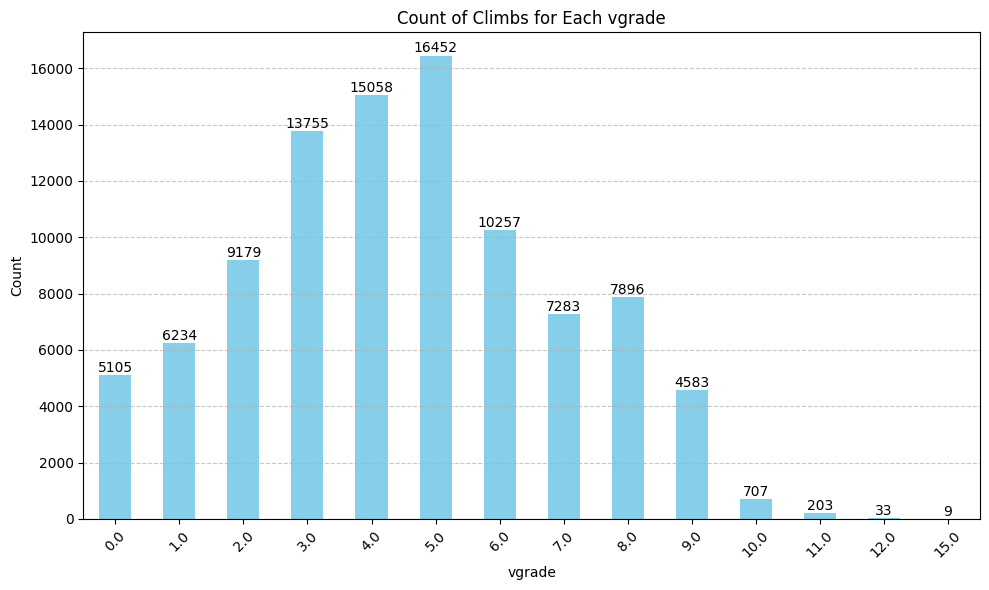

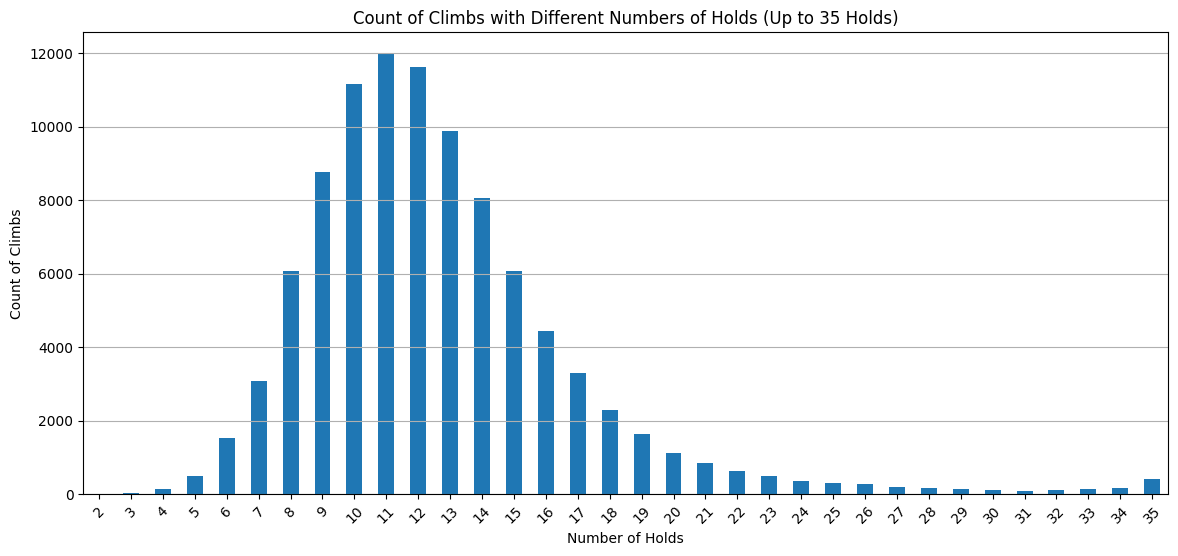

Average Number of Holds: 12.627250507046648


In [8]:
# Calculate vgrade counts
vgrade_counts = filtered_df['vgrade'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
bars = vgrade_counts.plot(kind='bar', color='skyblue')
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{int(height)}', ha='center', va='bottom')
plt.title('Count of Climbs for Each vgrade')
plt.xlabel('vgrade')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Assuming 'filtered_df' contains your DataFrame with the 'frames' column
filtered_df['hold_count'] = filtered_df['frames'].str.count('p')

# Filter out counts beyond 35 holds
filtered_counts = filtered_df['hold_count'].value_counts().sort_index().loc[:35]

# Plotting the count of climbs with a certain number of holds
plt.figure(figsize=(14, 6))  # Adjust the width by changing the first value (e.g., 14)
filtered_counts.plot(kind='bar')
plt.title('Count of Climbs with Different Numbers of Holds (Up to 35 Holds)')
plt.xlabel('Number of Holds')
plt.ylabel('Count of Climbs')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

total_hold_count = (filtered_counts.index * filtered_counts).sum()

# Calculate total count of climbs
total_climbs = filtered_counts.sum()

# Calculate average number of holds
average_holds = total_hold_count / total_climbs

print("Average Number of Holds:", average_holds)

### Preprocessing Data Functions

In [9]:
def id_to_index(id):
    
    if id <=1089: #bottom large (row) 17x1
        index_offset = 35
        row_index = 16 - (id - 1074)
        final_index = index_offset + 2 * row_index
    elif id <= 1395: #big holds (matrix) 17x18
        index_offset = 35 + 35
        index = id-1089
        row = index//17
        row_index = index%17
        final_index = index_offset + row * 70 + 2 *row_index   
    elif id <=1464: #bottom small (row) 18x1
        row_index = 17 - (id - 1447)
        final_index = 2 * row_index + 1
    elif id <= 1599: # small holds (matrix) 9x15
        index_offset = 35 + 35 + 35 + 1
        index = id-1464
        row = index//9
        row_index = index% 9
        final_index = index_offset + row * 70 + 4 * (row_index-1)
    else:
        final_index = id
        print(id) 
    return final_index

def id_to_coordinate(id):
    index = id_to_index(id)-1
    x = index % 35
    y = index//35
    if y >=35:
        y-=2 #because the top 2 rows of large hand holds dont have any feet so its offset
    return (x,y)

# ids = [1464,1447,1088,1089,1090,1107,1109, 1465]
# for id in range(len(ids)):
#     print(f"position {id+1}({ids[id]}): {id_to_index(ids[id])} {id_to_coordinate(ids[id])}")

# the value is:
# 2-feet 
# 3-start 
# 4-hand 
# 5-finish
def frame_to_ids(frame):
    ids_list_1 = []
    ids_list_2 = []
    
    # Split the frame string based on the 'p' delimiter
    filtered_frame = frame.replace(',', '').replace('"', '')
    frame_parts = filtered_frame.split('p')[1:]
    
    for entry in frame_parts:
        parts = entry.split('r')
        id_1 = int(parts[0])
        id_2 = int(parts[1])
        
        ids_list_1.append(id_1)
        if id_2 in [12, 13, 14, 15]:
            id_2 = [2, 3, 4, 5][id_2 - 12]
        ids_list_2.append(id_2)
    return ids_list_1, ids_list_2

# takes in frame and converts to list of triplets with xy being coordiante in board matrix and z being the value
def frame_to_triplets(frame):
    ids_list_1, ids_list_2 = frame_to_ids(frame)
    
    triplet_list = []
    for id_1, id_2 in zip(ids_list_1, ids_list_2):
        coordinate = id_to_coordinate(id_1)
        triplet = (coordinate[0], coordinate[1], id_2)
        triplet_list.append(triplet)
    
    return triplet_list

frame = "p1127r12p1164r12p1233r13p1235r13p1283r13p1287r13p1299r13p1348r13p1379r14p1458r15p1507r15"
triplet_list = frame_to_triplets(frame)
print("Triplet List:", triplet_list)

def triplets_to_matrix(triplet_list):
    # Initialize a 35x35 matrix with zeros
    matrix = [[0] * 35 for _ in range(35)]
    
    # Populate the matrix with z-values from the triplets
    for triplet in triplet_list:
        x, y, z = triplet
        matrix[34-y][x] = z
    
    return matrix

# matrix = triplets_to_matrix(triplet_list)
# for row in matrix:
#     print(row)

def frame_to_sparse_matrix(frame):
    triplet_list = frame_to_triplets(frame)
    matrix = triplets_to_matrix(triplet_list)
    sparse_matrix = sp.coo_matrix(matrix)
    return sparse_matrix

def is_frame_valid(frame):
    # Extract the first list of IDs from the frame
    if "x" in frame:
        return False
    ids_list_1, _ = frame_to_ids(frame)
    
    # Check if any value in the first list is greater than 2000
    for value in ids_list_1:
        if value > 2000:
            return False
    return True

Triplet List: [(7, 6, 2), (13, 10, 2), (15, 18, 3), (19, 18, 3), (13, 24, 3), (21, 24, 3), (11, 26, 3), (7, 32, 3), (1, 34, 4), (12, 0, 5), (24, 11, 5)]


### Create Training and Testing Sets from DF 
* preprocess the data
* convert to coo sparse matrix representations
* load into 2 pkl files

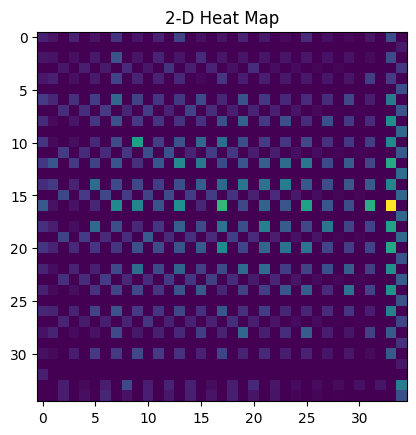

In [11]:
heatmap_matrix = [[0] * 35 for _ in range(35)]
for idx in range(len(filtered_df)):
    if is_frame_valid(filtered_df.iloc[idx]['frames']):
        triplets = frame_to_triplets(filtered_df.iloc[idx]['frames'])
        for triplet in triplets:
            heatmap_matrix[triplet[0]-1][triplet[1]-1] +=1

plt.imshow(heatmap_matrix)
plt.title("2-D Heat Map")
plt.show()

### Transformer Model

p1137r12p1169r12p1258r13p1309r13p1377r14p1451r15p1454r15p1517r15


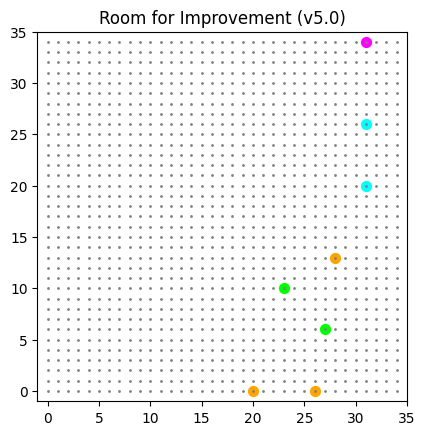

In [58]:
# pick a random frame and plot it
random_sample = filtered_df.sample()
frame = random_sample['frames'].values[0]
print(frame)
sparse_matrix = frame_to_sparse_matrix(frame)

# Define a function to plot a sparse matrix with different hold types as different colors
def plot_climb(sparse_matrix, title):
    # Define a dictionary to map hold values to colors
    hold_colors = {2: '#00FF00', 3: '#00FFFF', 4: '#FF00FF', 5: 'orange'}

    # Get the x, y, and z values from the sparse matrix
    x = sparse_matrix.col
    y = sparse_matrix.row
    z = sparse_matrix.data
    
    # Plot the sparse matrix with different hold types as different colors
    plt.xlim(-1, 35)
    plt.ylim(-1, 35)
    plt.gca().set_aspect('equal', adjustable='box')
    for i in range(len(x)):
        plt.scatter(x[i], 34 - y[i], color=hold_colors[z[i]], s=50)
    
    # plot every single point as a tiny grey dot to show graph
    for i in range(35):
        for j in range(35):
            plt.scatter(i, j, color='grey', s=1)
    
    # Set the title and labels
    plt.title(title)
    
    # Show the plot
    plt.show()

# Plot the sparse matrix with different hold types as different colors
plot_climb(sparse_matrix, f"{random_sample['name'].values[0]} (v{random_sample['vgrade'].values[0]})")



In [60]:
%pip install scikit-learn

  Using cached scikit_learn-1.4.1.post1-cp311-cp311-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.3.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.4.1.post1-cp311-cp311-macosx_12_0_arm64.whl (10.4 MB)
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Using cached threadpoolctl-3.3.0-py3-none-any.whl (17 kB)
Note: you may need to restart the kernel to use updated packages.


In [61]:
# Using the filtered_df, train a model to regress the difficulty of a climb based on the frame
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

def construct_features(triplets):
    # Example feature extraction
    features = []
    
    # Calculate aggregated features
    num_holds = len(triplets)
    hold_types = [t[2] for t in triplets]  # Assuming 'type' is the third element in the triplet
    hold_type_counts = {t: hold_types.count(t) for t in set(hold_types)}
    
    # Add more features based on your feature engineering
    # e.g., distances, relative positions, etc.
    
    # Append features for this configuration
    features.append([num_holds] + list(hold_type_counts.values()))
    
    return np.array(features)



ValueError: could not convert string to float: 'p1081r15p1150r12p1167r12p1198r15p1216r13p1254r13p1285r13p1298r13p1318r13p1332r13p1387r14p1469r15'

In [62]:
print(filtered_df.head())

                       name  vgrade  angle_y  display_difficulty  \
1     what kind of triangle     8.0       45             25.0000   
4               marks 1 try     2.0       30             14.0000   
5               marks 1 try     2.0       55             14.3333   
9   dead points (tristyn) 1     3.0       30             17.5000   
10                easy clap     4.0       45             19.3333   

                    created_at  ascensionist_count  \
1   2020-01-05 17:57:32.213641                   2   
4   2020-10-20 21:31:19.064510                   2   
5   2020-10-20 21:31:19.064510                   3   
9   2020-10-20 23:37:41.285379                   2   
10  2019-12-04 05:21:14.908093                   3   

                                               frames    fa_username  \
1   p1123r12p1139r13p1155r12p1171r13p1187r13p1203r...        bctyner   
4   p1141r15p1142r12p1144r15p1179r12p1192r13p1246r...  rob.hakansson   
5   p1141r15p1142r12p1144r15p1179r12p1192r13p1246r

In [64]:
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assuming df_filtered is your DataFrame with the columns 'frames', 'angle_y', 'display_difficulty'

# Step 1: Preprocess the Dataset
X_sparse_matrices = [frame_to_sparse_matrix(frame) for frame in filtered_df['frames']]
X_angle_y = np.array(filtered_df['angle_y']).reshape(-1, 1)  # Reshape for horizontal stack

# Convert list of COO matrices to a single sparse matrix
X_sparse = sp.vstack(X_sparse_matrices)

# Integrate angle_y as an additional feature
X = hstack([X_sparse, X_angle_y])

y = filtered_df['display_difficulty'].values

# Step 2: Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


ValueError: invalid literal for int() with base 10: '15x1460'